In [17]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [18]:
import pickle 

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra

from pprint import pp
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import ConstantBounds
from utils.cobra_utils import get_or_create_exchange
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes


MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"


# Load and set up model
model = read_sbml_model(MODEL_FILE)

# Set maintenance to 25 mmol/gDW/h
atpm = model.reactions.get_by_id("ATPM")
# atpm.bounds = (25, 25)

ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

In [19]:
df = pd.read_excel("../data/raw/growth/essentiality - July 2023.xlsx")
df = df[~df["Mutant (yes/no)"].isna()]
df["Essential"] = (df["Mutant (yes/no)"] == "no")

In [20]:
# Get fluxes when running on glucose, acetate
with model:
    ex_glc.bounds = (-10, 0)
    sol_glc = model.optimize()
    mu_glc = sol_glc.objective_value
    model.summary()
    print(f"Glucose growth: {sol_glc.objective_value:.2f}")

Glucose growth: 0.95


In [21]:
# We need to create a mapping from model genes to (index of) data genes
model_to_data_genes = {}

# Most genes in the model are ID'd by their RefSeq locus tag:
print(f"Model has {len(model.genes)} genes")

matched_by_rs_locus_tag = {}
for gene in model.genes:
    if "_RS" not in gene.id:
        continue

    match = (df[df["RefSeq_locus_tag"] == gene.id]
                if gene.id in df["RefSeq_locus_tag"].values
                else None)
    if match is not None:
        assert len(match) == 1
        matched_by_rs_locus_tag[gene] = match.index[0]

model_to_data_genes.update(matched_by_rs_locus_tag)
print(f"Model has {len([gene for gene in model.genes if "_RS" in gene.id])} genes ID'd by RefSeq locus tags")
print(f"{len(matched_by_rs_locus_tag)} genes in the model can be matched to essentiality data by RefSeq locus tag")

Model has 968 genes
Model has 147 genes ID'd by RefSeq locus tags
146 genes in the model can be matched to essentiality data by RefSeq locus tag


In [22]:
# Try locus tag for the remaining genes
remaining_genes = {gene for gene in model.genes if gene not in model_to_data_genes}

matched_by_locus_tag = {}
for gene in remaining_genes:
    if gene.id in df["locus_tag"].values:
        match = df[df["locus_tag"] == gene.id].index[0]
        matched_by_locus_tag[gene] = match

model_to_data_genes.update(matched_by_locus_tag)
print(f"Of the {len(remaining_genes)} remaining genes not ID'd by RefSeq locus tag, {len(matched_by_locus_tag)} can be matched by locus tag")

Of the 822 remaining genes not ID'd by RefSeq locus tag, 649 can be matched by locus tag


In [23]:
remaining_genes = {gene for gene in model.genes if gene not in model_to_data_genes}
lefts = [float(gene.notes["left-end-position"]) if "left-end-position" in gene.notes else None for gene in remaining_genes]
rights = [float(gene.notes["right-end-position"]) if "right-end-position" in gene.notes else None for gene in remaining_genes]

# Try to match by position for the remaining genes
matched_by_position = {}
for gene, left, right in zip(remaining_genes, lefts, rights):
    if left is None or right is None:
        print(f"Skipping {gene}")
        continue
    matches = df[((df["start"] == left) & (df["stop"] == right)) 
                 | (df["start"] == right) & (df["stop"] == left)]
    if len(matches) == 1:
        print(f"{gene} matched by position to {matches['locus_tag'].values[0]}")
        matched_by_position[gene] = matches.index[0]

model_to_data_genes.update(matched_by_position)

print(f"{len(matched_by_position)} out of {len(remaining_genes)} genes matched by position,")
print(f"\tleaving {len(remaining_genes) - len(matched_by_position)} genes unmatched.")

G1RHL-1475 matched by position to SPO1959
G1RHL-397 matched by position to SPO0579
G1RHL-1255 matched by position to SPO1674
G1RHL-2130 matched by position to SPO2806
G1RHL-271 matched by position to SPO0405
G1RHL-553 matched by position to SPO0800
G1RHL-2295 matched by position to SPO3012
G1RHL-1193 matched by position to SPO1594
G1RHL-2727 matched by position to SPO3597
G1RHL-2403 matched by position to SPO3152
G1RHL-1795 matched by position to SPO2385
G1RHL-1939 matched by position to SPO2565
G1RHL-354 matched by position to SPO0533
G1RHL-1474 matched by position to SPO1958
G1RHL-540 matched by position to SPO0785
G1RHL-360 matched by position to SPO0540
G1RHL-612 matched by position to SPO0876
G1RHL-2 matched by position to SPO0006
G1RHL-1552 matched by position to SPO2056
G1RHL-1511 matched by position to SPO2002
G1RHL-291 matched by position to SPO0435
G1RHL-396 matched by position to SPO0578
G1RHL-2087 matched by position to SPO2739
G1RHL-855 matched by position to SPO1193
G1RHL

In [24]:
for gene in remaining_genes:
    if len(gene.notes) == 0:
        print(f"Gene {gene} has no annotation")
        continue

Gene SPO02469 has no annotation


In [25]:
print("Remaining genes:")
remaining_genes = set(remaining_genes) - set(matched_by_position.keys())
for gene in remaining_genes:
    print(f"{gene.id} ({gene.notes})")

Remaining genes:
SPO_RS19330 ({'source': 'Ruegeria pomeroyi DSS-3 representative genome', 'synonyms': '[&apos;RS19330&apos;]', 'left-end-position': '4023398', 'right-end-position': '4023892', 'replicon': 'NC_003911'})
G1RHL-2982 ({'source': 'Ruegeria pomeroyi DSS-3', 'synonyms': '[]', 'left-end-position': '4175111', 'right-end-position': '4176298', 'replicon': 'DSS3'})
G1RHL-3191 ({'source': 'Ruegeria pomeroyi DSS-3', 'synonyms': '[]', 'left-end-position': '4480971', 'right-end-position': '4481918', 'replicon': 'DSS3'})
G1RHL-3105 ({'source': 'Ruegeria pomeroyi DSS-3', 'synonyms': '[]', 'left-end-position': '4334766', 'right-end-position': '4337792', 'replicon': 'DSS3'})
G1RHL-3123 ({'source': 'Ruegeria pomeroyi DSS-3', 'synonyms': '[]', 'left-end-position': '4374253', 'right-end-position': '4375176', 'replicon': 'DSS3'})
G1RHL-2960 ({'source': 'Ruegeria pomeroyi DSS-3', 'synonyms': '[]', 'left-end-position': '4126215', 'right-end-position': '4127387', 'replicon': 'DSS3'})
G1RHL-3235 (

100%|██████████| 937/937 [00:06<00:00, 152.61it/s]


(array([145.,   1.,   2.,   0.,   0.,   0.,   0.,  28.,   3., 758.]),
 array([-1.13228982e-12,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
         4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00]),
 <BarContainer object of 10 artists>)

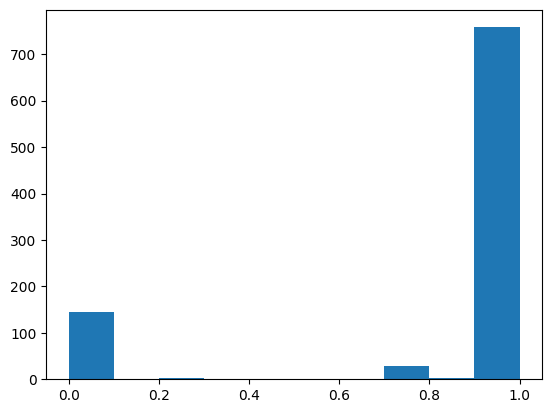

In [26]:
# Time to do the essentiality tests!!!
from tqdm import tqdm

with model:
    ex_glc.bounds = (-10, 0)
    sol = model.optimize()
    baseline = sol.objective_value

growth_rates = []
essentialities = []
for gene, index in tqdm(model_to_data_genes.items()):
    # Retrieve whether the gene is experimentally essential
    essential = df.loc[index]["Essential"]
    essentialities.append(essential)

    # Get model growth rate
    with model:
        ex_glc.bounds = (-10, 0)
        gene.knock_out()
        sol = model.optimize()
        growth_rates.append(sol.objective_value)
growth_rates = np.array(growth_rates)

fig, ax = plt.subplots()
ax.hist(growth_rates / baseline)

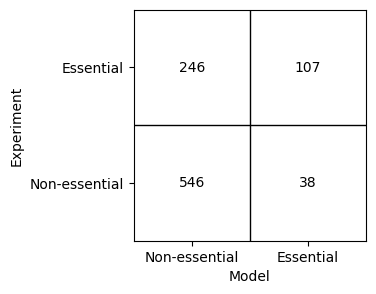

In [27]:
from collections import Counter

model_essential = (growth_rates < 1e-6)

fig, ax = plt.subplots()
for (model_x, data_y), count in Counter(zip(model_essential, essentialities)).items():
    ax.text(model_x/2 + 0.25,
            data_y/2 + 0.25,
            str(count),
            ha="center",
            va="center")

ax.vlines(0.5, 0, 1, "k", lw=1)
ax.hlines(0.5, 0, 1, "k", lw=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([.25, .75], ["Non-essential", "Essential"])
ax.set_yticks([.25, .75], ["Non-essential", "Essential"])
ax.set_xlabel("Model")
ax.set_ylabel("Experiment")

fig.set_size_inches(3, 3)

In [28]:
# Now, let's run a reaction essentiality test, so that we can relate the gene essentiality to the reaction essentiality
reaction_essentialities = []
for reaction in tqdm(model.reactions):
    with model:
        ex_glc.bounds = (-10, 0)
        reaction.knock_out()
        sol = model.optimize()
        reaction_essentialities.append(sol.objective_value)
reaction_essentialities = np.array(reaction_essentialities)
reaction_essentialities = reaction_essentialities < 1e-6
reaction_essentialities = dict(zip(model.reactions, reaction_essentialities))

100%|██████████| 1796/1796 [00:11<00:00, 161.07it/s]


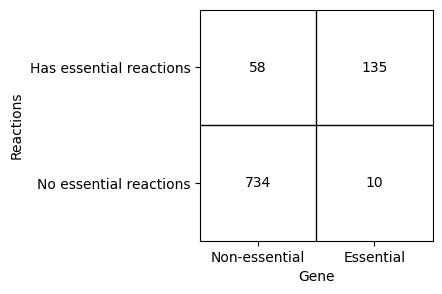

In [29]:
# Now we can relate the gene essentiality to the reaction essentiality
gene_reaction_categories = Counter()
strange = []
for gene, essentiality in zip(model_to_data_genes, model_essential):
    reactions = gene.reactions
    gene_reaction_essentialities = [reaction_essentialities[reaction] for reaction in reactions]
    has_essential_reactions = any(gene_reaction_essentialities)

    gene_reaction_categories[(essentiality, has_essential_reactions)] += 1

    if essentiality and not has_essential_reactions:
        strange.append(gene)

fig, ax = plt.subplots()
for (model_x, data_y), count in gene_reaction_categories.items():
    ax.text(model_x/2 + 0.25,
            data_y/2 + 0.25,
            str(count),
            ha="center",
            va="center")
ax.vlines(0.5, 0, 1, "k", lw=1)
ax.hlines(0.5, 0, 1, "k", lw=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([.25, .75], ["Non-essential", "Essential"])
ax.set_yticks([.25, .75], ["No essential reactions", "Has essential reactions"])
ax.set_xlabel("Gene")
ax.set_ylabel("Reactions")
fig.set_size_inches(3, 3)


In [30]:
for gene in strange:
    print(f"{gene.id}\n====================")
    for reaction in gene.reactions:
        print(f"\t{reaction.id} ({reaction_essentialities[reaction]})")

SPO0426
	NAD-SYNTH-NH3-RXN (False)
	NAD-SYNTH-GLN-RXN (False)
SPO0210
	RXN-18210 (False)
	RXNQT-4171 (False)
	RXNQT-4174 (False)
	RXNQT-4168 (False)
	RXNQT-4178 (False)
	RXN-14986 (False)
	RXN-18206 (False)
	RXN-18202 (False)
	RXN-18208 (False)
	3-ISOPROPYLMALDEHYDROG-RXN (False)
	RXN-13158 (False)
	RXNQT-4165 (False)
	RXN-18200 (False)
	RXN-18204 (False)
SPO1729
	HOMSUCTRAN-RXN (False)
	HOMOSERINE-O-ACETYLTRANSFERASE-RXN (False)
SPO1734
	HOMOSERDEHYDROG-RXN-HOMO-SER/NADP//L-ASPARTATE-SEMIALDEHYDE/NADPH/PROTON.53. (False)
	HOMOSERDEHYDROG-RXN-HOMO-SER/NAD//L-ASPARTATE-SEMIALDEHYDE/NADH/PROTON.51. (False)
SPO0059
	N-ACETYLTRANSFER-RXN (False)
	GLUTAMATE-N-ACETYLTRANSFERASE-RXN (False)
	RXN0-6948 (False)
SPO3855
	1.1.1.8-RXN (False)
	GLYC3PDEHYDROGBIOSYN-RXN-GLYCEROL-3P/NADP//DIHYDROXY-ACETONE-PHOSPHATE/NADPH/PROTON.59. (False)
SPO3207
	ISPH2-RXN (False)
	RXN0-884 (False)
SPO2109
	GMP-SYN-GLUT-RXN (False)
	GMP-SYN-NH3-RXN (False)
SPO1312
	RXN-14325 (False)
	CTPSYN-RXN (False)
SPO1777
	1.

In [31]:
# Check SPO_RS14555
gene = model.genes.get_by_id("SPO_RS14555")
with model:
    ex_glc.bounds = (-10, 0)
    gene.knock_out()
    sol = model.optimize()
    print(sol.objective_value)

KeyError: 'SPO_RS14555'